# Model Performance Monitoring with Weights & Biases

## Prerequisites

- Python 3.8+
- Google Colab (recommended) or local Jupyter
- W&B account and API key (Students: Settings → API Keys)

### Files/Resources Provided
- This notebook (you are reading it)

---
Run the cells below in order. Cells that require manual input are clearly indicated.


In [19]:
# Install required packages. In Colab this will install into the runtime.
!pip install --quiet wandb scikit-learn pandas matplotlib

print('Install complete.')

Install complete.


In [20]:
# Imports and quick version check
import sys
import sklearn
import pandas as pd
import wandb

print('Python:', sys.version.splitlines()[0])
print('scikit-learn:', sklearn.__version__)
print('pandas:', pd.__version__)
print('wandb import ok')

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
scikit-learn: 1.6.1
pandas: 2.2.2
wandb import ok


## Step 1 — Login to Weights & Biases

Run the cell below and follow the prompt to authenticate with your W&B API key. In Colab you will be asked to paste the key.

**Instructor tip:** For a classroom, you can create a shared team project and provide the `entity` name in `wandb.init()` cells.


In [21]:
# Login to W&B (interactive). In Colab this will prompt for your API key.
import wandb
wandb.login()
print('If login succeeded, you will see your W&B username above.')

If login succeeded, you will see your W&B username above.


## Step 2 — Load data and helper functions

This notebook uses the Iris dataset for simplicity. We provide helper functions to train, evaluate, and log runs to W&B.


In [22]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Load dataset
data = load_iris()
X = data['data']
y = data['target']
feature_names = data['feature_names']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Shapes: X_train', X_train.shape, 'X_test', X_test.shape)

Shapes: X_train (105, 4) X_test (45, 4)


In [23]:
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

## Step 3 — Training function: runs & logging

The `train_and_log` function trains a RandomForestClassifier, logs metrics, confusion matrix, and the model as an artifact to W&B.


In [24]:
import matplotlib.pyplot as plt
import io

def plot_confusion_matrix(cm, labels):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(cm, interpolation='nearest')
    ax.set_title('Confusion matrix')
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center')
    plt.tight_layout()
    return fig

def train_and_log(run_name, n_estimators=50, random_state=42, simulate_shift=False, entity=None, project='mlops-performance-monitoring'):
    """Train RandomForest and log to W&B.
    If simulate_shift=True, a small shift is added to X_test to emulate data drift.
    """
    run = wandb.init(project=project, name=run_name, entity=entity, reinit=True)
    wandb.config.update({'n_estimators': n_estimators, 'random_state': random_state})

    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    clf.fit(X_train, y_train)
    if simulate_shift:
        X_eval = X_test + np.random.normal(loc=0.5, scale=0.1, size=X_test.shape)
    else:
        X_eval = X_test
    preds = clf.predict(X_eval)
    acc = accuracy_score(y_test, preds)
    cr = classification_report(y_test, preds, output_dict=True)
    cm = confusion_matrix(y_test, preds)

    # Log metrics
    wandb.log({'accuracy': acc})
    # Log classification report as metrics
    for k, v in cr.items():
        if k.isdigit():
            wandb.log({f'class_{k}_precision': v['precision'], f'class_{k}_recall': v['recall'], f'class_{k}_f1': v['f1-score']})

    # Confusion matrix image
    fig = plot_confusion_matrix(cm, labels=data['target_names'])
    wandb.log({"confusion_matrix": wandb.Image(fig)})
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    plt.show()
    plt.close(fig)

    # Log model as artifact
    artifact = wandb.Artifact('rf-model', type='model')
    import joblib
    joblib.dump(clf, 'rf_model.joblib')
    artifact.add_file('rf_model.joblib')
    run.log_artifact(artifact)

    print(f'Run {run_name} logged. Accuracy = {acc:.4f}')

    return acc, run

## Step 4 — Baseline run

Run a baseline training run and observe metrics in your W&B project dashboard.


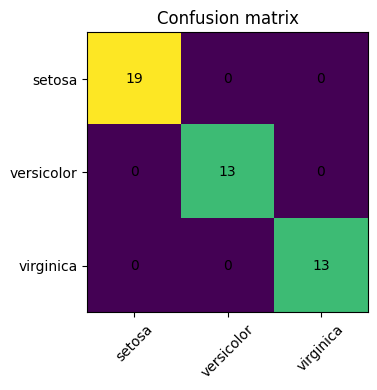

Run baseline-run logged. Accuracy = 1.0000


accuracy,▁
class_0_f1,▁
class_0_precision,▁
class_0_recall,▁
class_1_f1,▁
class_1_precision,▁
class_1_recall,▁
class_2_f1,▁
class_2_precision,▁
class_2_recall,▁
accuracy,1


1.0

In [25]:
# Baseline run
baseline_acc,run = train_and_log('baseline-run', n_estimators=50, random_state=42, entity="ir2023", project="MLOps Monitoring 142402006")
run.finish()
baseline_acc

## Step 5 — Simulate drift and run again

Now run the same model but simulate a small distribution shift in evaluation data to cause performance degradation. Compare the new run to the baseline in W&B UI.


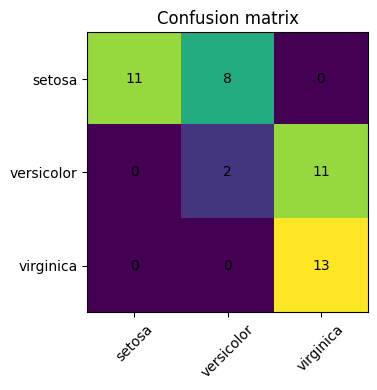

Run drifted-run logged. Accuracy = 0.5778


accuracy,▁
class_0_f1,▁
class_0_precision,▁
class_0_recall,▁
class_1_f1,▁
class_1_precision,▁
class_1_recall,▁
class_2_f1,▁
class_2_precision,▁
class_2_recall,▁
accuracy,0.57778


0.5777777777777777

In [26]:
# Drifted run (simulate data shift)
drifted_acc,run = train_and_log('drifted-run', n_estimators=50, random_state=99, simulate_shift=True, entity="ir2023", project="MLOps Monitoring 142402006")
run.finish()
drifted_acc

## Step 6 — Simple alerting example

W&B supports programmatic alerts. The snippet below demonstrates raising an alert when accuracy drops below a threshold. Alerts show up in the W&B UI (and can be configured to send emails or Slack messages in organization settings).


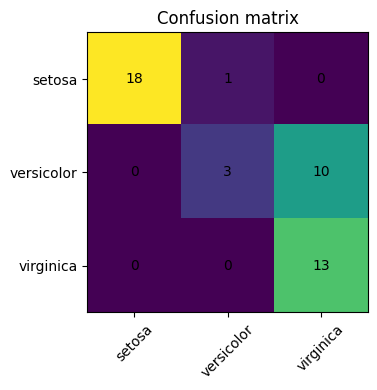

Run drifted-run logged. Accuracy = 0.7556
Alert sent (check W&B)


accuracy,▁
class_0_f1,▁
class_0_precision,▁
class_0_recall,▁
class_1_f1,▁
class_1_precision,▁
class_1_recall,▁
class_2_f1,▁
class_2_precision,▁
class_2_recall,▁
accuracy,0.75556


In [27]:
# This cell demonstrates programmatic alerting. Replace threshold as appropriate.
drifted_acc,run = train_and_log('drifted-run', simulate_shift=True, entity="ir2023", project="MLOps Monitoring 142402006")
threshold = 0.85
if drifted_acc < threshold:
    wandb.alert(title='Low accuracy detected', text=f'Accuracy {drifted_acc:.3f} below threshold {threshold}', level=wandb.AlertLevel.WARN)
    print('Alert sent (check W&B)')
else:
    print('Accuracy OK')

run.finish()